In [2]:
# Import libraries 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [31]:
df_2025 = pd.read_csv("ipl_2025_deliveries.csv")
df_2025.head(1)

,match_id,season,phase,match_no,date,venue,batting_team,bowling_team,innings,over,...,bowler,runs_of_bat,extras,wide,legbyes,byes,noballs,wicket_type,player_dismissed,fielder
0,202501,2025,Group Stage,1,"Mar 22, 2025","Eden Gardens, Kolkata",KKR,RCB,1,0.1,...,Hazlewood,0,0,0,0,0,0,NaN,NaN,NaN


In [4]:
# Explore the dataset
# df_2025[df_2025['wicket_type'].isna() == False].head(5)

In [5]:
# Filter the SRH bowlers who are playing in current season.
# Consider the bowlers of SRH who have bowled at least 2 overs in current season.

srh_bowlers_names_df = df_2025[df_2025['bowling_team'] == 'SRH'].groupby('bowler').agg(
    balls=('over', 'count')
).reset_index().query('balls > 6').sort_values(by='balls', ascending=False)

# Get the list of SRH bowlers who have bowled at least 2 overs in current season.
srh_bowlers_data = df_2025[df_2025['bowler'].isin(srh_bowlers_names_df['bowler'])]

In [6]:
srh_bowlers_names_df

,bowler,balls
1,Cummins,156
8,Shami,150
3,Harshal Patel,130
12,Zeeshan Ansari,113
9,Simarjeet Singh,63
2,Eshan Malinga,51
11,Zampa,50
0,Abhishek Sharma,49
5,Kamindu Mendis,12
10,Unadkat,12


#### Measuring Bowlers' Performance in SRH Team

The performance of SRH bowlers in this season can be evaluated based on the following metrics:

1. **Total Runs Conceded**: The total number of runs given by each bowler.
2. **Total Balls Bowled**: The total number of balls bowled by each bowler.
3. **Economy Rate**: Calculated as `(Total Runs Conceded) / (Total Overs Bowled)`. This metric indicates the average runs conceded per over.

Visualizations include:
- A heatmap showing total runs and balls bowled.
- A bar chart highlighting economy rates, sorted for better comparison.

In [7]:
def get_bowler_metrics_df(input_df: pd.DataFrame):
    # Group by bowler to get runs and ball count
    bowler_stats = input_df.groupby('bowler').agg(
        total_runs=('runs_of_bat', 'sum'),
        total_balls=('over', 'count'),
        total_wickets=('wicket_type', lambda x: x.notna().sum())
    ).reset_index()

    df = bowler_stats.pivot_table(
        values=['total_runs', 'total_balls', 'total_wickets'],
        index='bowler',
        aggfunc='sum'
    ).reset_index()

    df['economy_rate'] = (df['total_runs'] / (df['total_balls']/6)).round(2)
    df['strike_rate'] = (df['total_balls'] / df['total_wickets']).round(2)
    df['bowler_average'] = (df['total_runs'] / df['total_wickets']).round(2)
    
    # Convert 'inf' values to 'undefined'
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

Create a visualization for the performance metrics of bowlers. I use a heatmap here to check the aggregated data, and a bar chart to visualize the comparison of metrics.

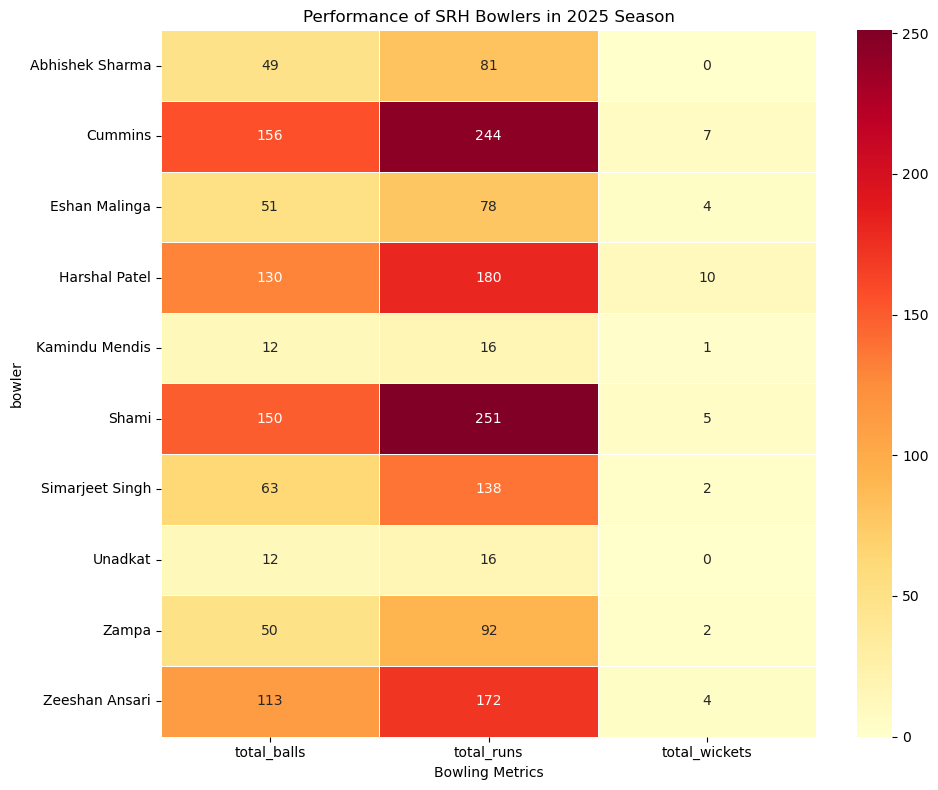

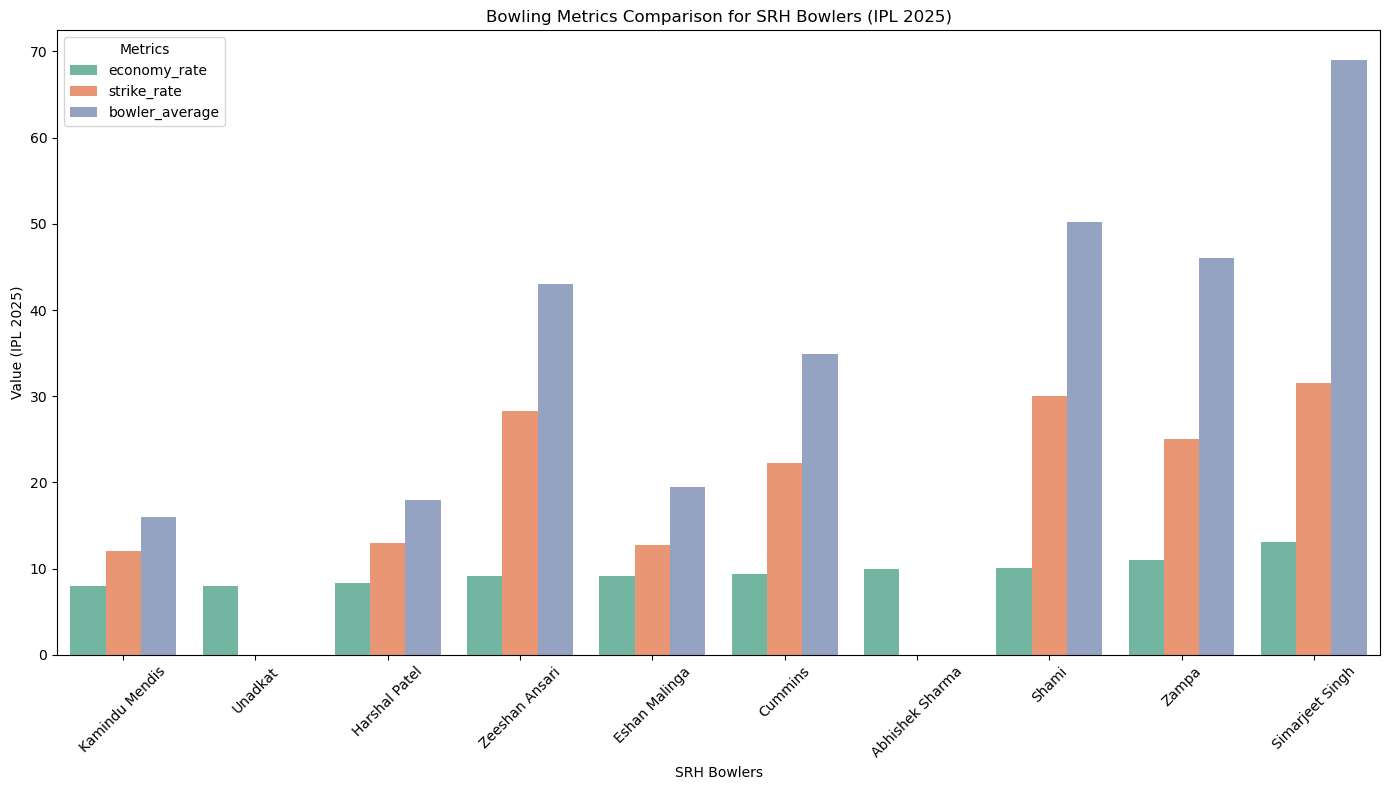

In [24]:
metrics_df = get_bowler_metrics_df(srh_bowlers_data)

# Reshape data for heatmap (convert from wide to long format)
heatmap_data = pd.melt(
        metrics_df, 
        id_vars='bowler',
        value_vars=['total_runs', 'total_balls', 'total_wickets'],
        var_name='Bowling Metrics',
        value_name='value'
    )

# Create a pivot table for the heatmap
heatmap_pivot = heatmap_data.pivot(index='bowler', columns='Bowling Metrics', values='value')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt=".0f", cmap="YlOrRd", linewidths=0.5)
plt.title("Performance of SRH Bowlers in 2025 Season")
plt.tight_layout()
plt.show()

# Plot economy rate as a bar chart
metrics_df = metrics_df.sort_values('economy_rate')

plt.figure(figsize=(14, 8))
long_df = pd.melt(
    metrics_df,
    id_vars='bowler',
    value_vars=['economy_rate', 'strike_rate', 'bowler_average'],
    var_name='Metric',
    value_name='Value'
)

# Create the plot
sns.barplot(
    data=long_df,
    x='bowler',
    y='Value',
    hue='Metric',
    palette='Set2'
)

plt.title('Bowling Metrics Comparison for SRH Bowlers (IPL 2025)')
plt.xlabel('SRH Bowlers')
plt.ylabel('Value (IPL 2025)')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# If you want to plot the bar chart only for a specific metric, e.g., economy rate:
# plt.figure(figsize=(12, 6))
# axis = sns.barplot(x='bowler', y='economy_rate', data=heatmap_df, palette='YlOrRd')
# plt.title('Economy Rate of SRH Bowlers (IPL 2025)')
# plt.ylabel('Economy Rate (runs per over) (IPL 2025)')
# plt.xlabel('SRH Bowlers')
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Add the values on top of the bars
# for i, v in enumerate(heatmap_df['economy_rate']):
#     axis.text(i, v + 0.1, str(v), ha='center')

# plt.show()

Now consider the segments of IPL T20 matches which are typically as below -

 - **Power play**: 0 - 5 overs
 - **Middle overs**: 6 - 15 overs
 - **Death overs**: 16 - 20 overs

Goal is to find out the performance metrics of each bowler against each segment of the match.

In [35]:
# Calculate metrics for each segment of the match
def get_segment_metrics(input_df: pd.DataFrame):
    input_df['segment'] = pd.cut(
        input_df['over'], 
        bins=[0, 6, 15, 20], 
        labels=['Power Play', 'Middle Overs', 'Death Overs'], 
        right=False
    )
    segment_stats = input_df.groupby(['bowler', 'segment']).agg(
        total_runs=('runs_of_bat', 'sum'),
        total_balls=('over', 'count'),
        total_wickets=('wicket_type', lambda x: x.notna().sum())
    ).reset_index()
    segment_stats['economy_rate'] = (segment_stats['total_runs'] / (segment_stats['total_balls'] / 6)).round(2)
    segment_stats['strike_rate'] = (segment_stats['total_balls'] / segment_stats['total_wickets']).round(2)
    segment_stats['bowler_average'] = (segment_stats['total_runs'] / segment_stats['total_wickets']).round(2)

    # Convert 'inf' values to 'undefined'
    segment_stats.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return segment_stats

C:\Users\satwikide\AppData\Local\Temp\ipykernel_10016\4239743413.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = input_df.groupby(['bowler', 'segment']).agg(
C:\Users\satwikide\AppData\Local\Temp\ipykernel_10016\1537715032.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = segment_metrics_2025.pivot_table(
C:\Users\satwikide\AppData\Local\Temp\ipykernel_10016\1537715032.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = se

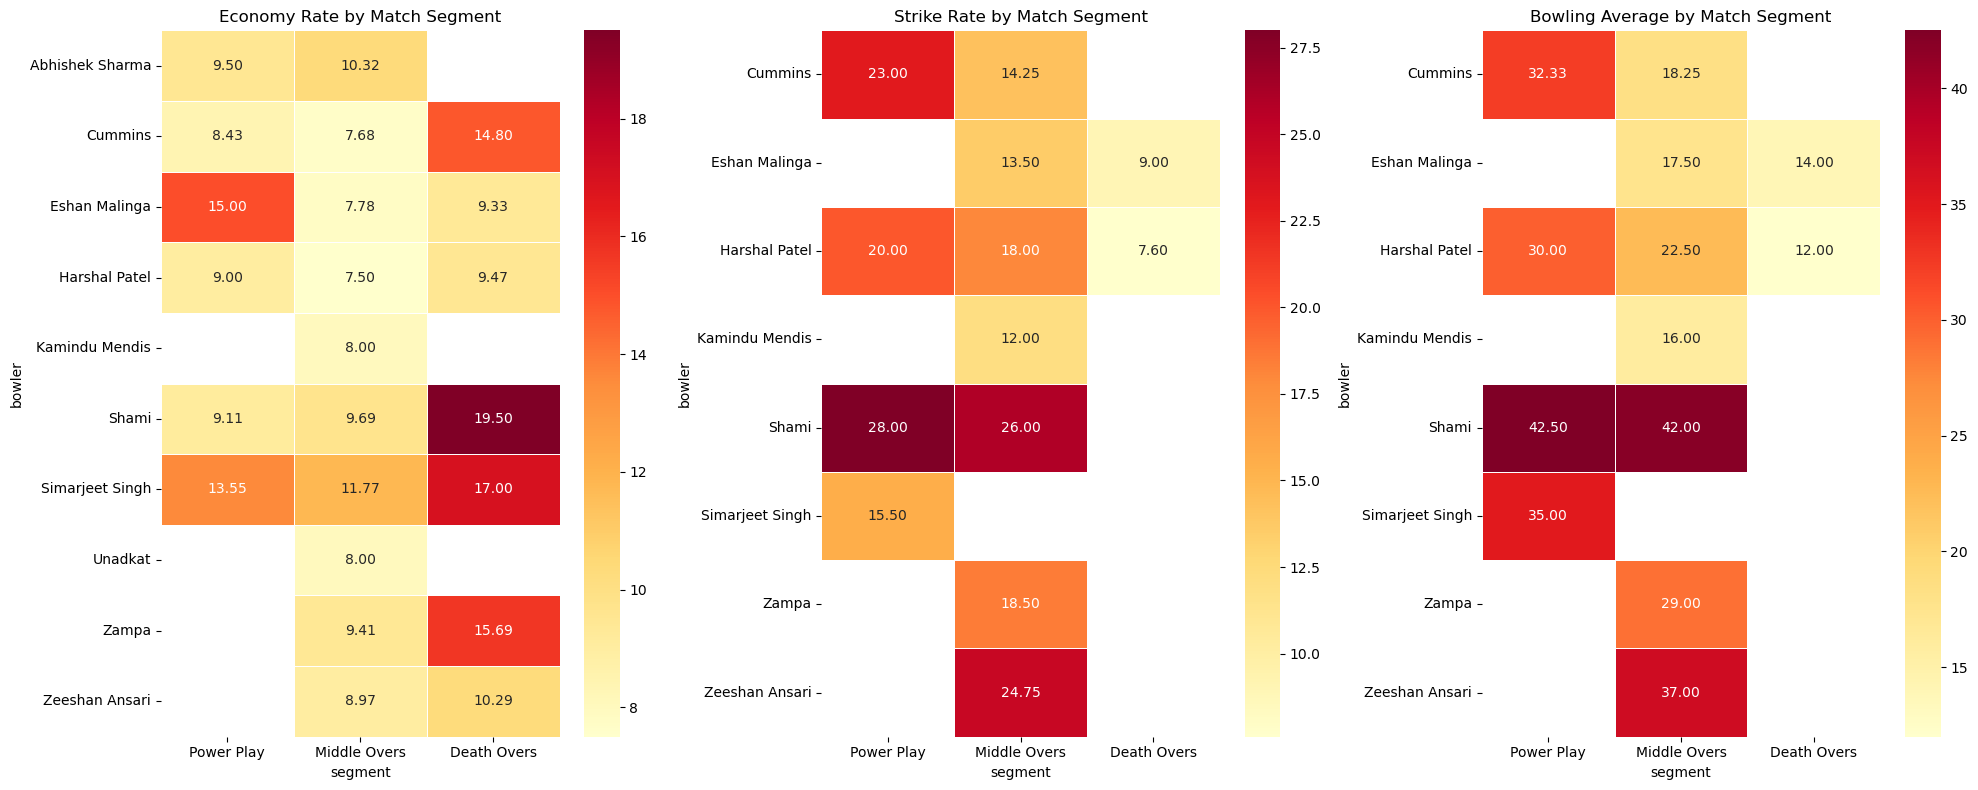

In [36]:
segment_metrics_2025 = get_segment_metrics(srh_bowlers_data)

metrics = ['economy_rate', 'strike_rate', 'bowler_average']
titles = ['Economy Rate', 'Strike Rate', 'Bowling Average']

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for i, (metric, title) in enumerate(zip(metrics, titles)):
    # Pivot the data for the heatmap
    heatmap_data = segment_metrics_2025.pivot_table(
        values=metric,
        index='bowler',
        columns='segment'
    )
    
    # Create the heatmap
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        cmap='YlOrRd', 
        linewidths=0.5, 
        fmt=".2f",
        ax=axes[i]
    )
    axes[i].set_title(f'{title} by Match Segment')

plt.tight_layout()
plt.show()

**Note:** The blank spaces in the chart does not missing data. The reason is either the bowler did not bowl in the specific segments, or has not yet taken a wicket.

#### Data-driven observations:

1. Harshal Patel has been consistently taking wickets in all segments while keeping economy rate on the lower side.
2. Shami has not been performing well, however keeping a fair economy rate in first 2 segments.


### Comparison with another team

Now shifting our focus to a team at top of the charts to check how their bowlers are performing. We'll plot the same segment-wise chart for the players of Gujarat Titans.

In [ ]:
gj_bowlers_names_df = df_2025[df_2025['bowling_team'] == 'GT'].groupby('bowler').agg(
    balls=('over', 'count')
).reset_index().query('balls > 6').sort_values(by='balls', ascending=False)

# Get the list of SRH bowlers who have bowled at least 2 overs in current season.
gj_bowlers_data = df_2025[df_2025['bowler'].isin(gj_bowlers_names_df['bowler'])]
gj_bowlers_data

C:\Users\satwikide\AppData\Local\Temp\ipykernel_10016\4239743413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['segment'] = pd.cut(
C:\Users\satwikide\AppData\Local\Temp\ipykernel_10016\4239743413.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_stats = input_df.groupby(['bowler', 'segment']).agg(
C:\Users\satwikide\AppData\Local\Temp\ipykernel_10016\3329018397.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this

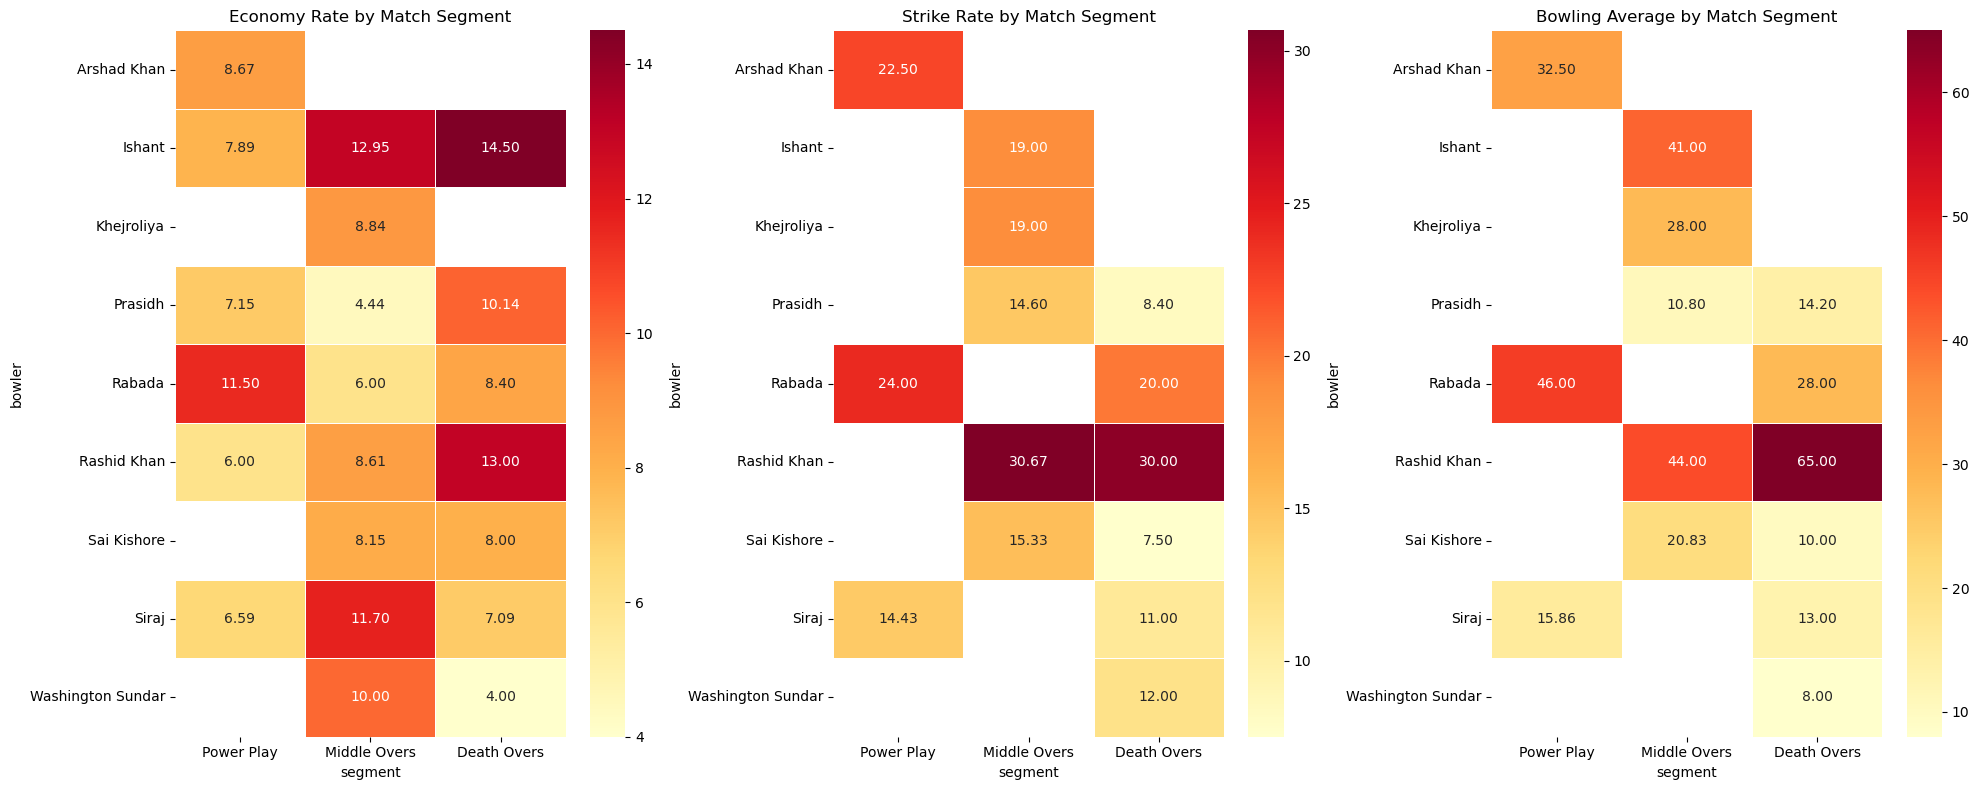

In [37]:
segment_metrics_gt_2025 = get_segment_metrics(gj_bowlers_data)

metrics = ['economy_rate', 'strike_rate', 'bowler_average']
titles = ['Economy Rate', 'Strike Rate', 'Bowling Average']

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for i, (metric, title) in enumerate(zip(metrics, titles)):
    # Pivot the data for the heatmap
    heatmap_data = segment_metrics_gt_2025.pivot_table(
        values=metric,
        index='bowler',
        columns='segment'
    )
    
    # Create the heatmap
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        cmap='YlOrRd', 
        linewidths=0.5, 
        fmt=".2f",
        ax=axes[i]
    )
    axes[i].set_title(f'{title} by Match Segment')

plt.tight_layout()
plt.show()

### Comparison:
1. GT clearly has Death over specialists with multiple bowlers taking wickets, while keeping a lower economy rate. 
1. Lower strike rate during power play compared to SRH, early advantage of taking out top order batsmen of the opponent.
1. GT has lower bowling average across the segments, better ability to adapt to match situations. On the other hand, SRH has too much variation in bowling average with Shami having highest ones.
1. A good economy rate with the maximum value being <15.
1. GT has built a more balanced and tactical bowling attack capable of performing in all match situations. SRH appears to rely more heavily on individual performers rather than having consistent team-wide bowling strength across all match phases.